In [ ]:
import numpy as np
import os
import pandas as pd
import string
import sys

from whoosh import scoring
from whoosh import qparser

Index all documents (i.e., text fragments) in the directory
* Create Schema
* Add documents
* Perform indexing

NB: this step only has to be run once, or when data is added or changed

In [ ]:
from baseline_search import create_searchable_data

In [ ]:
# Provide path to (NB: double nested) folder with text fragments
surf = "media/sf_MartinedeVos/surfdrive/Projects/EviDENce/"
search_dir = os.path.join(os.sep,surf,"Data","NR-Teksts","EviDENce_NR_output","Size200","fragmented_lemmas")

In [ ]:
# The creation of an index is only needed once; after, opending the existing index is sufficient
#create_searchable_data(search_dir)

Collect list of keywords from CEO-ECB mappings:
* remove pos-tag from each mention
* translate remaining lemma to Dutch 

In [ ]:
from baseline_search import create_lemma_list
from baseline_search import eng_to_dutch_list

In [ ]:
# Provide paths to (NB: double nested) documents folder and mapping file
mention_file ="../data/MdV_selectedCEOECB.csv"

In [ ]:
en_mentions = create_lemma_list(mention_file)

In [ ]:
# This is a workaround as google translate API is not working 
#(JSONCODECError;?problem with VirtualBox and network conection?)

prefab_file = "../data/nl_mentions.csv"
prefab_mentions = pd.read_csv(prefab_file,sep=';',encoding = "ISO-8859-1")
nl_mentions = list(prefab_mentions["Mention"])

for en,nl in zip(en_mentions, nl_mentions):
    print(en,'->',nl)

To do: 
* run lemmas on docs
* try out scoring and ranking
* plot violence occurence over fragments (x: # hits, y: # documents)
* plot types of violence pver fragments

Preprocess list of keywords to be used in search engine:
* sort
* concatenate in one query string

In [ ]:
from baseline_search import quote_phrases

nl_mention_set = set(nl_mentions)
nl_mention_list = list(nl_mention_set)

quoted_nl_mention_list = quote_phrases (nl_mention_list)
quoted_nl_mention_list

nl_mention_query = ",".join(quoted_nl_mention_list)
nl_mention_query

In [ ]:
from whoosh.index import open_dir

indexdir = os.path.join(os.sep,search_dir,"indexdir")
ix = open_dir(indexdir)

For given query display:
* number of relevant documents overall:
    * hit vs no-hit
    * hits per keyword

In [65]:
import pandas as pd
from whoosh import qparser
from whoosh.index import open_dir

indexdir = os.path.join(os.sep,search_dir,"indexdir")
ix = open_dir(indexdir)

parser = qparser.QueryParser("content", schema=ix.schema,group=qparser.OrGroup)
my_query = parser.parse(nl_mention_query)

rows_list = []
titles_list = []

with ix.searcher(weighting=scoring.TF_IDF()) as searcher:
    results = searcher.search(my_query,limit=None, terms = True)
    for res in results:
        titles_list.append(res["title"])
        #row_dict = {key:0 for key in my_quoted_list}
        row_dict = {}
        hits = [term.decode('utf8')  for where,term in res.matched_terms()]
        for hit in hits:
            # Could this be prettier? defaultdict does not allow custom-set keys, and dict.get()
            # seems to change all other values into NaN if one of them has a hit
            row_dict[hit] = row_dict.get(hit, 0) + 1        
            #if hit in row_dict:
             #   row_dict[hit]+= 1
            #else:
             #   pass
        rows_list.append(row_dict)
        
df = pd.DataFrame(rows_list)
df.insert(0,'title',titles_list)

In [69]:
all_terms = {key:0 for key in quoted_nl_mention_list}
missed_terms = [term for term in all_terms.keys() if not term in df]

new_columns = df.columns.tolist()+ missed_terms
df = df.reindex(columns = new_columns)

df.fillna(0,inplace=True)

df['sum_docs'] = df.sum(axis=1)
df.loc['sum_keywords'] = df.sum()
df


,title,aanval,alarm,arm,arresteren,bedreiging,behandelen,beneden,beroerte,beschadigd,...,vlogen,"""het schieten""",mensenjacht,intrappen,bedwelmen,"""omver gooien""",geschutvuur,uitvoering,total hits docs,sum_docs
0,GV_Traktor_Russenoorlog_03_conversation_clippe...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
1,GV_SiteFilms_Java_03_conversation_clipped_200_85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0
2,GV_Traktor_Russenoorlog_07_conversation_clippe...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,15.0
3,GV_Traktor_Russenoorlog_01_conversation_clippe...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,15.0
4,GV_Zigma_koopvaardij_06_conversation_clipped_2...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
5,GV_Zigma_koopvaardij_06_conversation_clipped_2...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
6,GV_Verhalis_kloosterzusters_02b_conversation_c...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,15.0
7,GV_Zigma_koopvaardij_04_conversation_clipped_2...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0
8,GV_Schiedam_gastgezin2_09_conversation_clipped...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
9,GV_Zigma_koopvaardij_01_conversation_clipped_2...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0


Data exploration:
    * Original corpus size
    * Search results: corpus size
    * Search results: nr keywords per document
    * Search results: nr hits per keyword 

In [68]:
import matplotlib.pyplot as plt

all_docs = ix.searcher().documents() 
sum_docs = sum(1 for x in all_docs)

percent_hits = (2080/4292)*100

print("Original corpus size: %s"%sum_docs)
print("Search results corpus size: %s"%len(df['title']))
print("Percentage documents in search results: %s"%percent_hits)


Original corpus size: 4292
Search results corpus size: 2081
Percentage documents in search results: 48.462255358807084


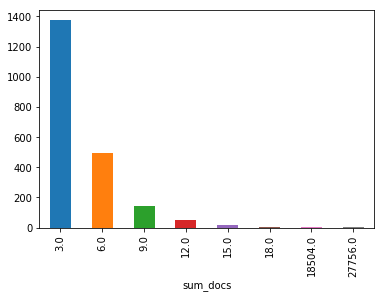

In [70]:
df.groupby(['sum_docs']).count()['title'].plot(kind='bar')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

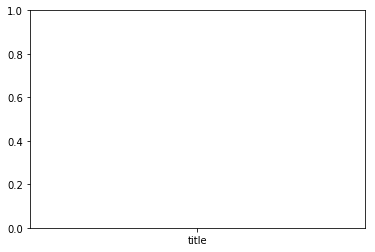

In [87]:
hit_keywords = df.loc[:, ~df.isnull().all()].iloc[:-2,-2]

keywords = df.columns[:-2]

plt.bar(keywords,hit_keywords)
plt.show()